### Individuazione dell'impulso negli esperimenti con materiale omogeneo, in particolare sul ferro. (No attenuazione?)
##### Prima picking sull'onda, direi che basta un sta/lta. Poi:
####  Misura della velocita' e della sua incertezza, data l'incertezza sul cammino percorso e sul picking 
#### attenuazione dell'ampiezza: studiare se e' solo geometrical spreading o anche
#### perdita delle alte frequenze

In [211]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from LAb_UW_functions import *
from math import ceil

In [212]:
def sta_lta(waveform, sta_window, lta_window, energy=True):
    """
    Implements the STA/LTA algorithm on a 1D signal.

    Args:
    - signal: 1D numpy array representing the input signal.
    - sta_window: Length of the short-term average window (in samples).
    - lta_window: Length of the long-term average window (in samples).

    Returns:
    - A numpy array representing the STA/LTA ratio.
    """

    if energy:
        waveform = waveform**2      # do the sta/lta on the energy of the signal

    # Calculate STA (Short-Term Average)
    sta = np.convolve(np.abs(waveform), np.ones(sta_window), mode='same') / sta_window

    # Calculate LTA (Long-Term Average)
    lta = np.convolve(np.abs(waveform), np.ones(lta_window), mode='same') / lta_window

    # Calculate STA/LTA ratio
    sta_lta_ratio = sta / lta

    return sta_lta_ratio

def relative_argmax_given_known_numbers_of_them(waveform, chunk_n = 5, offset = 0, tolerance = 0.1):
    chunk_len = ceil(len(waveform)/chunk_n)
    index_max_list = []
    index_min_before_list = []
    index_min_after_list = []

    for chunk in range(chunk_n):
        start = offset + chunk_len*chunk
        end = start+chunk_len
        chunk_max = np.amax(waveform[start:end])
        idx_chunk_max = np.argmax(waveform[start:end])
        # print(f"{chunk} start = {start}")
        # print(f"{chunk} end = {end}")
        # print(f"{chunk} chunk max = {idx_chunk_max}")


        # For each chunk, these are the absolute minimum before and after the maximum. 
        chunk_min_before = np.amin(waveform[start:start+idx_chunk_max])
        idx_chunk_min_before = np.argmin(waveform[start:start+idx_chunk_max])
        # print(f'idx min chunk before = {idx_chunk_min_before}')

        chunk_min_after = np.amin(waveform[start+idx_chunk_max:end])
        idx_chunk_min_after = idx_chunk_max + np.argmin(waveform[start+idx_chunk_max:end])
        # print(f'idx min chunk after = {idx_chunk_min_after}')

        # But, to get tight mimimums around the maximum, here there is an interative procedure
        # Given a tolerance value, it is accepted the closer values to the maximum that are "minimum enough" compared to the absolute minimum
        # This shold avoid to get a larger pick in case of a flat behaviour around it, as should be if 
        # - the sta/lta parameters are properly chosen
        # - the signal does not have copies of himself too close
         
        search_interval = idx_chunk_max-idx_chunk_min_before
        # print(f"{chunk} before search_interval = {search_interval}")
        mask_wave = chunk_max * np.ones(len(waveform[start:end]))

        for idx in range(2,search_interval,5):
            mask_wave[idx_chunk_max-idx:idx_chunk_max] = waveform[start+idx_chunk_max-idx:start+idx_chunk_max]
            difference = np.amin(mask_wave) - chunk_min_before
            if difference < tolerance:
                # print(f"idx_chunk_min_before = {idx_chunk_min_before}")
                idx_chunk_min_before = np.argmin(mask_wave) 
                break

        search_interval = idx_chunk_min_after-idx_chunk_max
        # print(f"{chunk} after search_interval = {search_interval}")
        mask_wave = chunk_max * np.ones(len(waveform[start:end]))
        
        for idx in range(2,search_interval,5):
            mask_wave[idx_chunk_max:idx_chunk_max+idx] = waveform[start+idx_chunk_max:start+idx_chunk_max+idx]
            difference = np.amin(mask_wave) - chunk_min_after
            if difference < tolerance:
                idx_chunk_min_after = np.argmin(mask_wave) 
                # print(f"idx_chunk_min_after = {idx_chunk_min_after}")
                break
            
        index_max = idx_chunk_max + start
        index_min_before = idx_chunk_min_before + start
        # print(f"{chunk} index_min_before = {idx_chunk_min_before}")

        index_min_after = idx_chunk_min_after + start 
        # print(f"{chunk} index_min_after = {index_min_after}")

        index_max_list.append(index_max)
        index_min_before_list.append(index_min_before)
        index_min_after_list.append(index_min_after)

    return index_max_list, index_min_before_list, index_min_after_list

def picking_plot(time,waveform,ratio, index_max_list, index_min_before_list, index_min_after_list):

    # Plot the data vs sta_lta picking
    plt.plot(time, waveform, label='Waveform')
    norm = (np.amax(waveform)/np.amax(ratio))
    plt.plot(time, norm*ratio, label='STA/LTA of Waveform')
    plt.plot(time[index_max_list], norm*ratio[index_max_list], "r.")
    plt.plot(time[index_min_before_list], norm*ratio[index_min_before_list], "g.")
    plt.plot(time[index_min_after_list], norm*ratio[index_min_after_list], "k.")

    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.title('STA/LTA Picking')
    plt.plot()

    # plt.xlim([0, 20])

    plt.show()


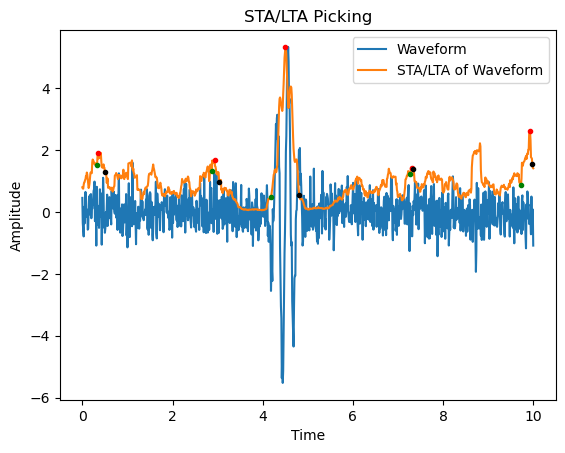

In [213]:

# Example usage of sta/lta
# Generate a synthetic signal and check the right sta_window and lta_window to maximize the ratio
# We already know the feature of the signal we want to see, and we can accordingly choose the sta/lta windows

nsamples = 1000
time = np.linspace(0, 10, nsamples)

noise_amplitude = 0.5
noise = np.random.normal(0, noise_amplitude, nsamples)

signal = np.zeros(noise.shape)

winlen = 100
square_start = 400
amp_square = 5
mask = amp_square * np.hanning(winlen)
signal[square_start:square_start+winlen] = mask

frequency = 4  # Hz
amplitude = 1
sin_signal = np.sin(2 * np.pi * frequency * time[square_start:square_start+winlen])
signal[square_start:square_start+winlen] =  mask * sin_signal

waveform = signal + noise


# Compute STA/LTA ratio
sta_window = 20        # best choice: twice the sinusoidal frequency
lta_window = 200       # best choice: twice the winlen of the hanning window

ratio = sta_lta(waveform, sta_window, lta_window)
index_max_list, index_min_before_list, index_min_after_list = relative_argmax_given_known_numbers_of_them(ratio, chunk_n=5, tolerance=1 )
picking_plot(time, waveform,ratio, index_max_list, index_min_before_list, index_min_after_list)



In [214]:
# Try in real data

machine_name = "on_bench"
experiment_name = "glued_pzt"
# machine_name = "Brava_2"
# experiment_name = "s0098"
remove_initial_samples = 50    # number of samples to be removed at the beginning, to get rid of the noise burst.

infile_path_list = make_infile_path_list(machine_name,experiment_name)
infile_path = infile_path_list[4]

# for infile_path in infile_path_list:
print('PROCESSING UW DATA IN %s: ' %infile_path)



        

PROCESSING UW DATA IN /home/michele/Desktop/Dottorato/active_source_implementation/experiments_on_bench/glued_pzt/data_tsv_files/PIS1_PIS2_glued_100V.bscan.tsv: 


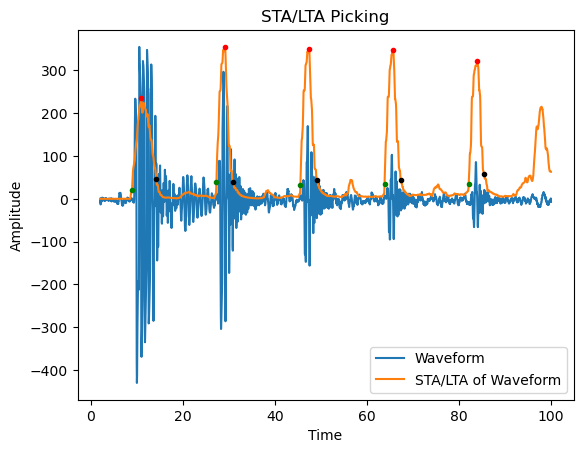

In [215]:
data,metadata = make_UW_data(infile_path)
data,metadata = remove_starting_noise(data, metadata, remove_initial_samples)
x_ax = metadata['time_ax_waveform']

# windows must be:
sta_window = 2*ceil(1/ metadata['sampling_rate'])         # twice the number of samples of the pzt pulse that is, its resonance frequency
lta_window = 2*ceil(8/ metadata['sampling_rate'])         # twice the number of samples of the pulses train
number_of_pulse = 5                                       # it can be calculated by length of the sample and theoretical reasoning on velocity boundary

waveform = data[4,:]
# for waveform in data:
ratio = sta_lta(waveform, sta_window, lta_window)
index_max_list, index_min_before_list, index_min_after_list = relative_argmax_given_known_numbers_of_them(ratio, chunk_n=5, tolerance=1)
picking_plot(x_ax, waveform,ratio, index_max_list, index_min_before_list, index_min_after_list)
